In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read in the dataset
weather = pd.read_csv("weather_dataset.csv", index_col = "DATE")

# check the proportion of missing values for each column
weather.apply(pd.isnull).sum()/weather.shape[0]

# the description of the dataset tells us the core columns of the dataset. So, make new dataset with core columns
core_weather = weather[['PRCP','SNOW','SNWD','TMAX','TMIN']].copy()

# rename columns
core_weather.columns = ['precip', 'snow', 'snow_depth', 'temp_max', 'temp_min']

# check the proportion of missing values for each column
core_weather.apply(pd.isnull).sum()/core_weather.shape[0]

# Many missing values for snowdepth cuz of no snow on that day. So, change from NaN to 0
core_weather['snow_depth'] = core_weather['snow_depth'].fillna(0)

# check the proportion of missing values for each column
core_weather.apply(pd.isnull).sum()/core_weather.shape[0]

# drop all missing values since dataset is big and only small percentage is missing
core_weather = core_weather.dropna()

# change index to datetime index for special features later on
core_weather.index = pd.to_datetime(core_weather.index)

# dataset description said 9999 means missing value. So check if any missing values.
core_weather.apply(lambda x: (x==9999).sum())

# create new row with each value in the "temp_max" column is moved to the row above it
core_weather["target"] = core_weather.shift(-1)['temp_max']

# Since there is no row above the last row, it produces NaN, so I removed it.
core_weather = core_weather.iloc[:-1,:].copy()

core_weather.dtypes

core_weather

,precip,snow,snow_depth,temp_max,temp_min,target
DATE,,,,,,
1950-01-01,0.00,0.0,0.0,44,32,40.0
1950-01-02,0.01,0.0,0.0,40,31,56.0
1950-01-03,0.07,0.0,0.0,56,40,64.0
1950-01-04,0.00,0.0,0.0,64,55,61.0
1950-01-05,0.03,0.0,0.0,61,45,45.0
...,...,...,...,...,...,...
2022-12-27,0.00,0.0,0.0,36,28,43.0
2022-12-28,0.00,0.0,0.0,43,24,54.0
2022-12-29,0.00,0.0,0.0,54,32,63.0


,actual,predictions
DATE,,
1956-01-31,36.0,36.747959
1956-02-01,42.0,38.026102
1956-02-02,40.0,40.807023
1956-02-03,32.0,36.659143
1956-02-04,43.0,33.070304
...,...,...
2022-12-27,43.0,39.037999
2022-12-28,54.0,41.208313
2022-12-29,63.0,47.581164


error is 6.018144141489935 

reg coef are [-2.04579906 -0.3845956  -0.05598468  0.39015047  0.24929051 -0.01316587
  0.45347456  0.06797764  0.14907149  0.23247841] 

Correlation: 
 precip            -0.060404
snow              -0.204211
snow_depth        -0.259874
temp_max           0.888276
temp_min           0.886877
target             1.000000
month_max          0.842264
month_day_max     -0.337761
max_min           -0.200800
monthly_avg        0.862085
day_of_year_avg    0.873703
Name: target, dtype: float64 



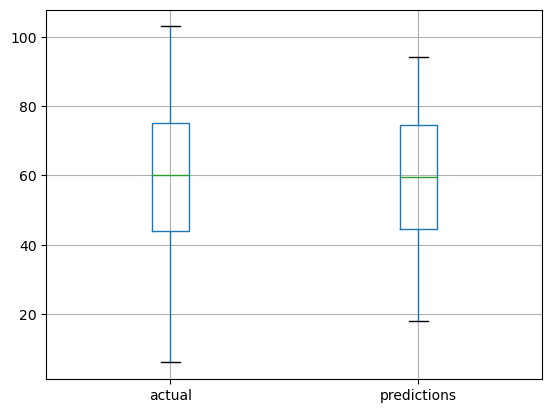

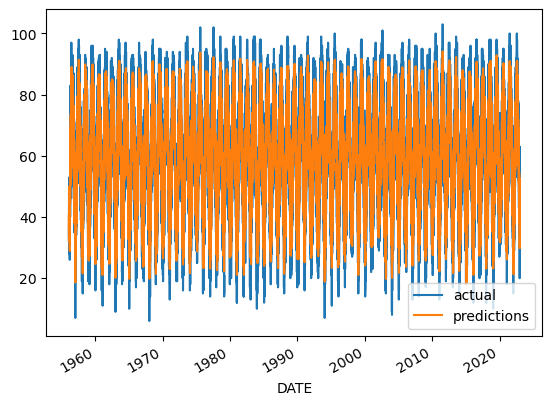

In [158]:
from sklearn.linear_model import Ridge 
reg = Ridge(alpha=.1)
from sklearn.metrics import mean_absolute_error

# create a function to train the dataset, test it, generate predictions, find error, and concatenate
def create_predictions(predictors, train, reg):
    reg.fit(train[predictors], train['target'])
    predictions = reg.predict(test[predictors])
    error = mean_absolute_error(test["target"], predictions)
    combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
    combined.columns = ["actual", "predictions"]
    return error, combined

combined.boxplot(column = ["actual", "predictions"])

# create more predictors
core_weather["month_max"] = core_weather["temp_max"].rolling(30).mean()
core_weather["month_day_max"] = core_weather["month_max"] / core_weather["temp_max"]
core_weather["max_min"] = core_weather["temp_max"] / core_weather["temp_min"]

# delete first 30 rows because of missing values that were generated from rolling(30)
core_weather = core_weather.iloc[30:,:].copy()

# droped 17 na values because temperature min was 0 so it is an infinite/undefined value
core_weather = core_weather.replace(np.inf, np.nan)
core_weather = core_weather.dropna()

# create more predictors
core_weather["monthly_avg"] = core_weather["temp_max"].groupby(core_weather.index.month).apply(lambda x: x.expanding(1).mean())
core_weather["day_of_year_avg"] = core_weather["temp_max"].groupby(core_weather.index.day_of_year).apply(lambda x: x.expanding(1).mean())

train = core_weather.iloc[:2010-12-31].copy()
test = core_weather.iloc[2011-1-1:].copy()

# add predictors
predictors = ['precip', 'snow', 'snow_depth', 'temp_max', 'temp_min', 'month_max', 'month_day_max', 'max_min', 'monthly_avg', 'day_of_year_avg']
# send predictors, dataset, and reg to function
error, combined = create_predictions(predictors, core_weather, reg)

display(combined)
combined.plot()

combined["diff"] = (combined['actual'] - combined['predictions']).abs()
combined.sort_values("diff", ascending=False).head()

print("error is", error,"\n") 
print("reg coef are",reg.coef_, "\n")
print('Correlation:','\n', core_weather.corr()["target"],'\n')


In [159]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor()
regressor.fit(train[predictors], train['target'])
predictions = regressor.predict(test[predictors])

error = mean_absolute_error(test["target"], predictions)
print("Mean Absolute Error:", error)

Mean Absolute Error: 6.294275127942681


In [160]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# create more predictors
train["month_max"] = train["temp_max"].rolling(30).mean()
train["month_day_max"] = train["month_max"] / train["temp_max"]
train["max_min"] = train["temp_max"] / train["temp_min"]

# delete first 30 rows because of missing values that were generated from rolling(30)
train = train.iloc[30:,:].copy()

# droped 17 na values because temperature min was 0 so it is an infinite/undefined value
train = train.replace(np.inf, np.nan)
train = train.dropna()

# create more predictors
train["monthly_avg"] = train["temp_max"].groupby(train.index.month).apply(lambda x: x.expanding(1).mean())
train["day_of_year_avg"] = train["temp_max"].groupby(train.index.day_of_year).apply(lambda x: x.expanding(1).mean())

regressor = RandomForestRegressor()
regressor.fit(train[predictors], train['target'])
predictions = regressor.predict(test[predictors])

error = mean_absolute_error(test["target"], predictions)
print("Mean Absolute Error:", error)

feature_importances = regressor.feature_importances_
print("Feature Importances:", feature_importances)

standard_error = np.std(train["temp_max"]) / np.sqrt(len(train["temp_max"]))
print(standard_error)

Mean Absolute Error: 6.3167938587512795
Feature Importances: [0.01515673 0.00142275 0.00105439 0.17928065 0.2112333  0.02803428
 0.02498354 0.03080113 0.13603634 0.3719969 ]
0.4043583889115137


In [161]:
from sklearn.model_selection import train_test_split

core_weather["month_max"] = core_weather["temp_max"].rolling(30).mean()
core_weather["month_day_max"] = core_weather["month_max"] / core_weather["temp_max"]
core_weather["max_min"] = core_weather["temp_max"] / core_weather["temp_min"]

# delete first 30 rows because of missing values that were generated from rolling(30)
core_weather = core_weather.iloc[30:,:].copy()

# droped 17 na values because temperature min was 0 so it is an infinite/undefined value
core_weather = core_weather.replace(np.inf, np.nan)
core_weather = core_weather.dropna()

# create more predictors
core_weather["monthly_avg"] = core_weather["temp_max"].groupby(core_weather.index.month).apply(lambda x: x.expanding(1).mean())
core_weather["day_of_year_avg"] = core_weather["temp_max"].groupby(core_weather.index.day_of_year).apply(lambda x: x.expanding(1).mean())

core_weather_train = core_weather.drop('target', axis=1).copy()

x_train, x_test, y_train, y_test = train_test_split(core_weather_train, core_weather['target'], test_size=0.2, random_state=42)


In [162]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create the Linear Regression model
model = LinearRegression()

# Train the model on the training data
model.fit(x_train, y_train)

# Make predictions on the test data
predictions = model.predict(x_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, predictions)
r_squared = r2_score(y_test, predictions)

# Print the evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r_squared)

Mean Squared Error: 55.81828000334398
R-squared: 0.8323334614899817


In [163]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

regressor = RandomForestRegressor()
regressor.fit(x_train, y_train)
predictions = regressor.predict(x_test)

error = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error:", error)

feature_importances = regressor.feature_importances_
print("Feature Importances:", feature_importances)

standard_error = np.std(train["temp_max"]) / np.sqrt(len(train["temp_max"]))
print(standard_error)

Mean Absolute Error: 6.090039765195986
Feature Importances: [0.0137383  0.00227132 0.00168402 0.1263668  0.67396082 0.02396227
 0.02411224 0.02339163 0.03294852 0.07756406]
0.4043583889115137


In [164]:
from sklearn.neural_network import MLPRegressor

regressor = MLPRegressor()
# Train the model on the training data
regressor.fit(x_train, y_train)

# Make predictions on the test data
predictions = regressor.predict(x_test)

error = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error:", error)

Mean Absolute Error: 6.011426267652956
